In [ ]:
https://drive.google.com/file/d/1xQ0UhTBv3gwJyoEKXTOkD8UD1QXNqDgt/view?usp=drive_link

SyntaxError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
import imutils
import cv2
from tensorflow.keras.preprocessing import image

from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions

1/1 [==============================] - 1s 593ms/step
Predicted class index: 0
Predicted label: AD GAMMA
Confidence: 0.99981385


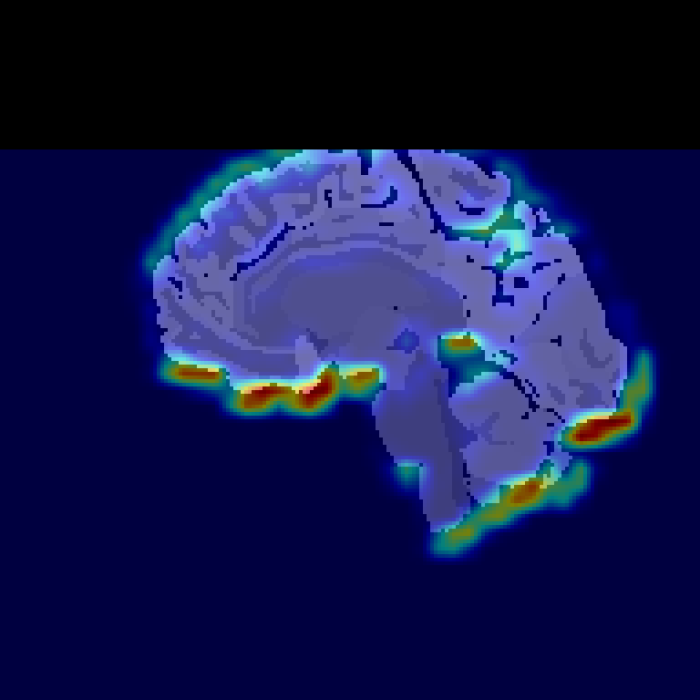

In [ ]:



model = load_model('/content/drive/MyDrive/Models/MIDSAG.h5')

# Load and preprocess the image
#AD WITH GAMMA PREPROCESSING
#image_path = '/content/drive/MyDrive/FINAL/Train Gamma/AD GAMMA 0.2/ADNI_014_S_1095_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070320181218511_S23323_I4574013958.png'
#MCI with GAMMA PREPROCESSING
#image_path = '/content/drive/MyDrive/Models/pmci_ADNI_002_S_0729_MR_MPR__GradWarp__B1_Correction__N3__Scaled_2_Br_20081001115616920_S16874_I1186823186.png'
#AD WITHOUT GAAMMA PROCESSING
#image_path = '/content/drive/MyDrive/Models/soory.png'
#PMCI WITHOUT GAMMA PREPROCESSING
#image_path = '/content/drive/MyDrive/Models/pmsoory.png'
#IMAGE WITH NOT SKULL STRIP AD
image_path = '/content/drive/MyDrive/16 07/GAMMA ENHANCED  copy/To upload/AD/S_0083_MR_MPR__GradWarp__B1_Correction__N3__Scaled_2_Br_20081001153941224_S10568_I118874.nii.gz_slice76.png'

orig = cv2.imread(image_path)
"""
def adjust_gamma(image, gamma):
    table = np.array([((i / 255.0) ** gamma) * 255 for i in np.arange(0, 256)]).astype('uint8')
    return cv2.LUT(image, table)

gamma = 0.2  # Specify the gamma value for enhancement

# Apply gamma enhancement to the original image
orig = adjust_gamma(orig, gamma)"""

resized = cv2.resize(orig, (180, 180))

gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
gray = np.expand_dims(gray, axis=-1)  # Add an extra dimension for grayscale channel

image = img_to_array(gray)
image = np.expand_dims(image, axis=0)
image = image.astype('float32') / 255.0

# Make predictions
preds = model.predict(image)
predicted_class_index = np.argmax(preds[0])

# Print the predicted class index
print("Predicted class index:", predicted_class_index)

class_labels = {
    0: "AD GAMMA",
    1: "MCI GAMMA"
    # Add more class labels as needed
}

# Get the predicted label based on the class index
label = class_labels[predicted_class_index]
print("Predicted label:", label)

# Print the confidence score
confidence = preds[0][predicted_class_index]
print("Confidence:", confidence)


class GradCAM:
    def __init__(self, model, predicted_class_index, layer_name=None):
        self.model = model
        self.predicted_class_index = predicted_class_index
        self.layer_name = layer_name

        if self.layer_name is None:
            self.layer_name = self.find_target_layer()

    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output.shape) == 4:
                return layer.name

        raise ValueError("Could not find 4D layer and cannot apply GradCAM")

    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(inputs=[self.model.inputs], outputs=[self.model.get_layer(self.layer_name).output, self.model.output])

        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.predicted_class_index]

        grads = tape.gradient(loss, convOutputs)

        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype('uint8')
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_JET):
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        return heatmap, output


cam = GradCAM(model, predicted_class_index)

heatmap = cam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
heatmap, output = cam.overlay_heatmap(heatmap, orig, alpha=0.5)
cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
#cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
#output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)
#cv2_imshow("Output", output)
cv2_imshow(output)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
normalized_heatmap = (flattened_heatmap - flattened_heatmap.min()) / (flattened_heatmap.max() - flattened_heatmap.min())


NameError: ignored

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
import cv2

from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model


model = load_model('/content/drive/MyDrive/Models/MIDSAG.h5')

image_folder = '/content/drive/MyDrive/16 07/GAMMA ENHANCED  copy/To upload/AD'

# Get the list of image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]

class_labels = {
    0: "AD GAMMA",
    1: "MCI GAMMA"
    # Add more class labels as needed
}

# Set up the subplot grid
num_images = len(image_files)
num_cols = 5
num_rows = (num_images + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3*num_rows))

# Process each image in the folder
for i, image_file in enumerate(image_files):
    # Load the image
    image_path = os.path.join(image_folder, image_file)
    orig = cv2.imread(image_path)

    resized = cv2.resize(orig, (180, 180))

    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    gray = np.expand_dims(gray, axis=-1)  # Add an extra dimension for grayscale channel

    image = img_to_array(gray)
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32') / 255.0

    # Make predictions
    preds = model.predict(image)
    predicted_class_index = np.argmax(preds[0])

    # Get the predicted label based on the class index
    label = class_labels[predicted_class_index]
    print("Predicted label:", label)

    # Compute GradCAM heatmap
    cam = GradCAM(model, predicted_class_index)
    heatmap = cam.compute_heatmap(image)
    heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
    heatmap = 1 - heatmap

    # Overlay the heatmap on the original image
    heatmap, output = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

    # Save the output image
    ##output_path = os.path.join(image_folder, f"processed_{image_file}")
    ##cv2.imwrite(output_path, output)

    # Display the image and heatmap in the subplot
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx, col_idx]
    ax.imshow(output)
    ax.set_title(label)
    ax.axis('off')

    print("Processed:", image_file)

# Remove any unused subplots
if num_images < num_rows * num_cols:
    for i in range(num_images, num_rows * num_cols):
        row_idx = i // num_cols
        col_idx = i % num_cols
        axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()

print("Image processing complete.")


1/1 [==============================] - 0s 150ms/step
Predicted label: MCI GAMMA
Processed: SMCI_S_0285_MR_MPR_GradWarp_B1_Correction_N3_Scaled_Br_S12462_I39117.nii.gz_slice78.png
1/1 [==============================] - 0s 80ms/step
Predicted label: MCI GAMMA
Processed: SMCI_S_0107_MR_MPR__GradWarp__B1_Correction__N3__Scaled_2_Br_20081008132433778_S11707_I119701.nii.gz_slice75.png
1/1 [==============================] - 0s 86ms/step
Predicted label: MCI GAMMA
Processed: SMCI_S_0004_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20070804134614900_S9234_I64631.nii.gz_slice75.png
1/1 [==============================] - 0s 83ms/step
Predicted label: MCI GAMMA
Processed: SMCI_S_0225_MR_MPR__GradWarp__N3__Scaled_2_Br_20081007094139944_S11679_I119377.nii.gz_slice84.png
1/1 [==============================] - 0s 87ms/step
Predicted label: MCI GAMMA
Processed: SMCI_S_0324_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20061212171617702_S12599_I32891.nii.gz_slice77.png
1/1 [======================

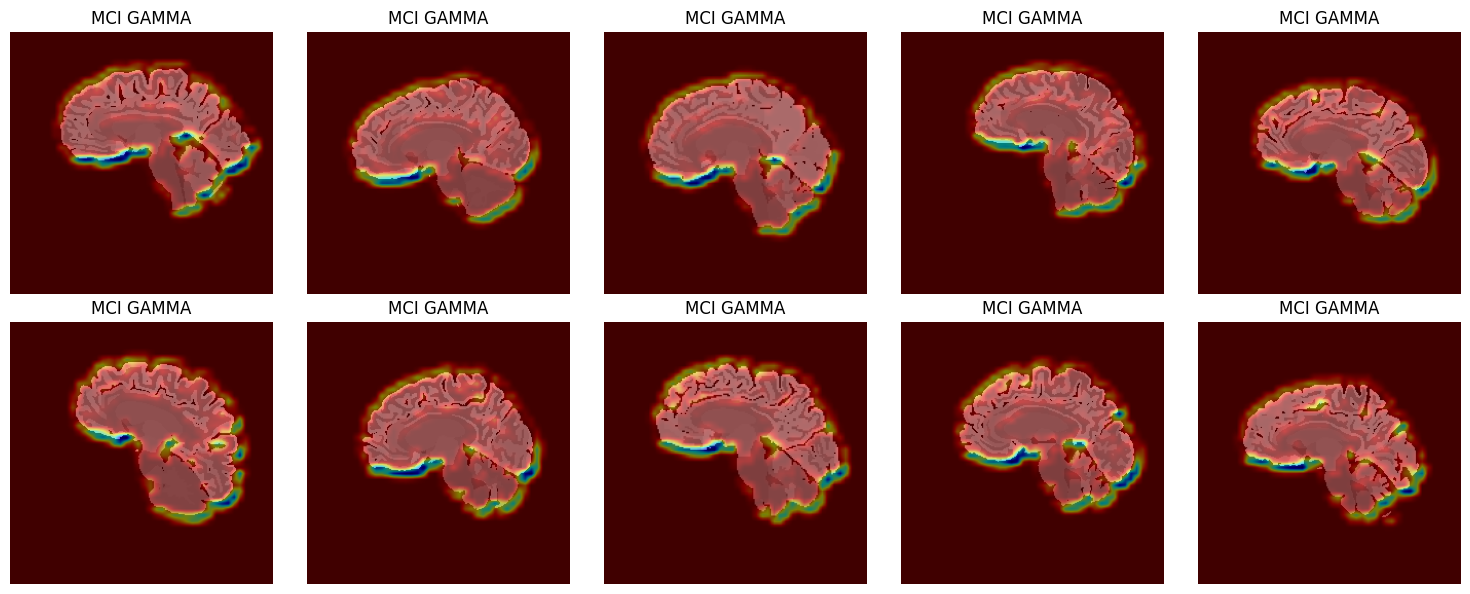

Image processing complete.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
import cv2

from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model


model = load_model('/content/drive/MyDrive/Models/MIDSAG.h5')

image_folder = '/content/drive/MyDrive/16 07/GAMMA ENHANCED  copy/To upload/SMCI'

# Get the list of image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]

class_labels = {
    0: "AD GAMMA",
    1: "MCI GAMMA"
    # Add more class labels as needed
}

# Set up the subplot grid
num_images = len(image_files)
num_cols = 5
num_rows = (num_images + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3*num_rows))

# Process each image in the folder
for i, image_file in enumerate(image_files):
    # Load the image
    image_path = os.path.join(image_folder, image_file)
    orig = cv2.imread(image_path)

    resized = cv2.resize(orig, (180, 180))

    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    gray = np.expand_dims(gray, axis=-1)  # Add an extra dimension for grayscale channel

    image = img_to_array(gray)
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32') / 255.0

    # Make predictions
    preds = model.predict(image)
    predicted_class_index = np.argmax(preds[0])

    # Get the predicted label based on the class index
    label = class_labels[predicted_class_index]
    print("Predicted label:", label)

    # Compute GradCAM heatmap
    cam = GradCAM(model, predicted_class_index)
    heatmap = cam.compute_heatmap(image)
    heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
    #heatmap = 1 - heatmap

    # Overlay the heatmap on the original image
    heatmap, output = cam.overlay_heatmap(heatmap, orig, alpha=0.5)


    # Save the output image
    ##output_path = os.path.join(image_folder, f"processed_{image_file}")
    ##cv2.imwrite(output_path, output)

    # Display the image and heatmap in the subplot
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx, col_idx]
    ax.imshow(output)
    ax.set_title(label)
    ax.axis('off')

    print("Processed:", image_file)

# Remove any unused subplots
if num_images < num_rows * num_cols:
    for i in range(num_images, num_rows * num_cols):
        row_idx = i // num_cols
        col_idx = i % num_cols
        axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()

print("Image processing complete.")


# New Section

1/1 [==============================] - 0s 236ms/step
Predicted label: AD GAMMA
Processed: S_0003_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20061208111300610_S9127_I32237.nii.gz_slice74.png
1/1 [==============================] - 0s 100ms/step
Predicted label: AD GAMMA
Processed: S_0088_MR_MPR____N3__Scaled_2_Br_20081006154519230_S10795_I119277.nii.gz_slice81.png
1/1 [==============================] - 0s 69ms/step
Predicted label: AD GAMMA
Processed: S_0084_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_2_Br_20081002100834283_S10764_I118970.nii.gz_slice76.png
1/1 [==============================] - 0s 64ms/step
Predicted label: AD GAMMA
Processed: S_0183_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20061206183315171_S12000_I32003.nii.gz_slice75.png
1/1 [==============================] - 0s 66ms/step
Predicted label: MCI GAMMA
Processed: S_0194_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_2_Br_20081008133147404_S13178_I119717.nii.gz_slice78.png
1/1 [==============================]

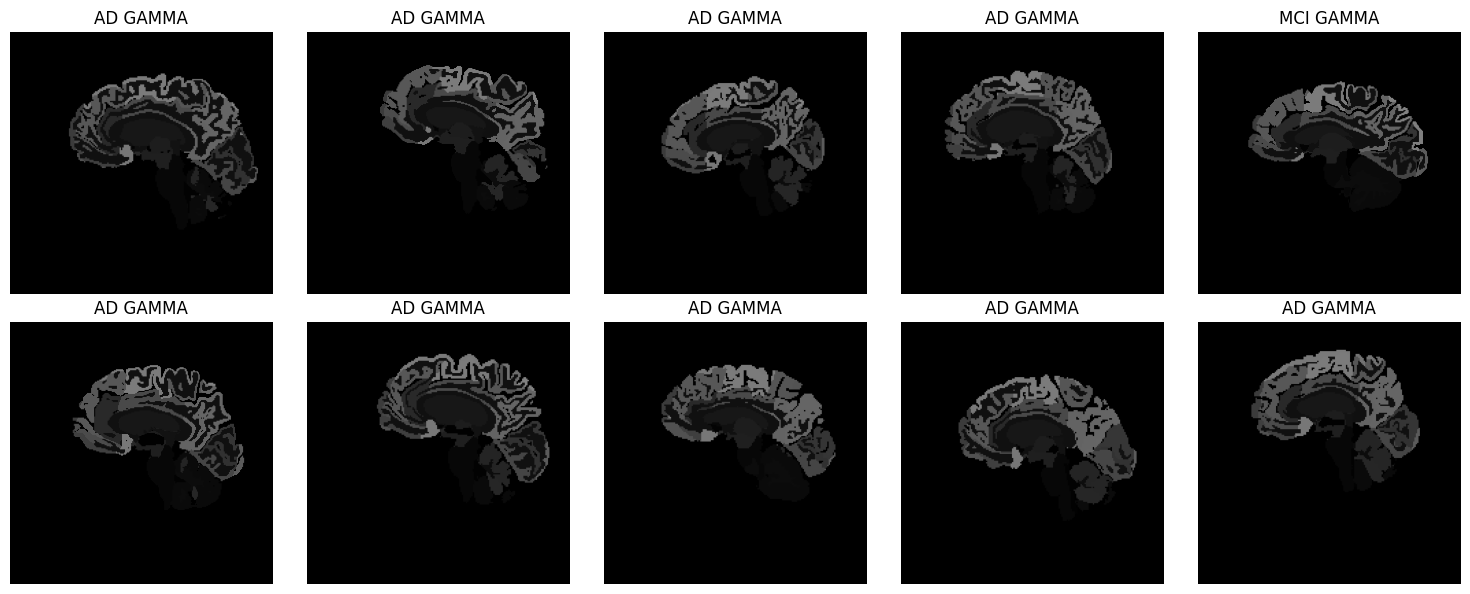

Image processing complete.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
import cv2

from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model


model = load_model('/content/drive/MyDrive/Models/MIDSAG.h5')

image_folder = '/content/drive/MyDrive/16 07/GAMMA ENHANCED  copy/To upload/AD MIDSAGNOGAMMA'

# Get the list of image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]

class_labels = {
    0: "AD GAMMA",
    1: "MCI GAMMA"
    # Add more class labels as needed
}

# Set up the subplot grid
num_images = len(image_files)
num_cols = 5
num_rows = (num_images + num_cols - 1) // num_cols

# Define transparency level for overlaying the heatmap
alpha = 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3*num_rows))

# Process each image in the folder
for i, image_file in enumerate(image_files):
    # Load the image
    image_path = os.path.join(image_folder, image_file)
    orig = cv2.imread(image_path)

    resized = cv2.resize(orig, (180, 180))

    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    gray = np.expand_dims(gray, axis=-1)  # Add an extra dimension for grayscale channel

    image = img_to_array(gray)
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32') / 255.0

    # Make predictions
    preds = model.predict(image)
    predicted_class_index = np.argmax(preds[0])

    # Get the predicted label based on the class index
    label = class_labels[predicted_class_index]
    print("Predicted label:", label)

    # Compute GradCAM heatmap
    cam = GradCAM(model, predicted_class_index)
    heatmap = cam.compute_heatmap(image)
    heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))

    # Overlay the heatmap on the original image
    heatmap, output = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

    # Convert the heatmap to grayscale
    heatmap_gray = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)

    # Threshold the grayscale heatmap to create a binary mask of ROIs
    _, roi_mask = cv2.threshold(heatmap_gray, 0, 255, cv2.THRESH_BINARY)

    # Apply the binary mask to the original image to show only the ROIs in color
    roi_image = cv2.bitwise_and(orig, orig, mask=roi_mask)

    # Create a black background image
    background = np.zeros_like(orig)

    # Combine the ROI image with the black background to show only the ROIs in color
    output = cv2.addWeighted(background, 1-alpha, roi_image, alpha, 0)

    # Display the image and heatmap in the subplot
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx, col_idx]
    ax.imshow(output)
    ax.set_title(label)
    ax.axis('off')

    print("Processed:", image_file)

# Remove any unused subplots
if num_images < num_rows * num_cols:
    for i in range(num_images, num_rows * num_cols):
        row_idx = i // num_cols
        col_idx = i % num_cols
        axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()

print("Image processing complete.")
